Large-Scale Data Mining: Models and Algorithms,
Niklas Zwingenberger,
03/19/2023

Note: as it wasn't really clear from Piazza or the assignment instructions whether to do a train-test split, I have opted to do so just in case. This also makes preprocessing and standardisation fairer as otherwise we are effectively fitting them to our test data.

In [77]:
import scipy.stats
%load_ext autoreload
%autoreload 2
import seaborn as sns
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import zscore
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from IPython.core.display_functions import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from scipy.stats import linregress
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings
from sklearn.utils import parallel_backend
from typing import List
import time
from skopt import BayesSearchCV
from scipy.stats import pearsonr
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from skopt.space import Real, Integer
from lightgbm import LGBMRegressor
from lightgbm import early_stopping
import json
from datetime import datetime
from collections import defaultdict
import pytz
from typing import Optional
from tqdm import tqdm
from scipy.stats import skew
import graphviz
from sklearn import tree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# Import data
seed = 42
gases = ['CO', 'NOX']
chosen_gas = 'NOX'

# We suppress various convergence warnings to keep the submission code more readable.
warnings.filterwarnings("ignore")


def filter_parallel_warnings(func, *args):
    with parallel_backend("multiprocessing"):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            return func(*args)


example_df = pd.read_csv('pp_gas_emission/gt_2011.csv')
all_files = glob.glob(os.path.join(f'{os.getcwd()}/pp_gas_emission', "*.csv"))

li = []
# According to UCI source entries in each CSV are chronological
# https://archive.ics.uci.edu/ml/datasets/Gas+Turbine+CO+and+NOx+Emission+Data+Set
# All attributes:
# Variable (Abbr.) Unit Min Max Mean
# Ambient temperature (AT) C â€“6.23 37.10 17.71
# Ambient pressure (AP) mbar 985.85 1036.56 1013.07
# Ambient humidity (AH) (%) 24.08 100.20 77.87
# Air filter difference pressure (AFDP) mbar 2.09 7.61 3.93
# Gas turbine exhaust pressure (GTEP) mbar 17.70 40.72 25.56
# Turbine inlet temperature (TIT) C 1000.85 1100.89 1081.43
# Turbine after temperature (TAT) C 511.04 550.61 546.16
# Compressor discharge pressure (CDP) mbar 9.85 15.16 12.06
# Turbine energy yield (TEY) MWH 100.02 179.50 133.51
# Carbon monoxide (CO) mg/m3 0.00 44.10 2.37
# Nitrogen oxides (NOx) mg/m3 25.90 119.91 65.29

for idx, filename in enumerate(sorted(all_files)):
    year = filename.split('.')[0][-4:]
    df = pd.read_csv(filename, index_col=None, header=0)
    df['year'] = int(year)
    print(f'year: {year}, size {df.size}')
    li.append(df)

base_df = pd.concat(li, axis=0, ignore_index=True)
gases.remove(chosen_gas)
data_df = base_df.drop(gases[0], axis=1)
print(f'total size: {base_df.size}')
data_df.head()

year: 2011, size 88932
year: 2012, size 91536
year: 2013, size 85824
year: 2014, size 85896
year: 2015, size 88608
total size: 440796


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,NOX,year
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,81.952,2011
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,82.377,2011
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,83.776,2011
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,82.505,2011
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,82.028,2011


# Question 1

## Pearson Correlation Heatmap

In [79]:
train_X, test_X, train_Y, test_Y = train_test_split(data_df.drop(columns='NOX'), data_df['NOX'], test_size=0.2,
                                                    random_state=seed)

<AxesSubplot: >

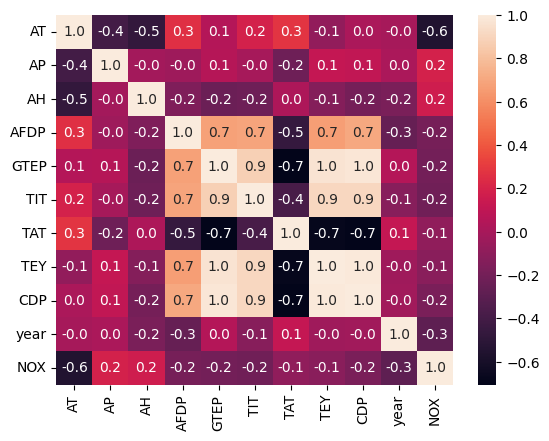

In [80]:
t_data_df = train_X.copy(deep=True)
t_data_df['NOX'] = train_Y
corr_matrix = t_data_df.corr(method='pearson')

sns.heatmap(corr_matrix, annot=True, fmt='.1f')

We can observe that there is a strong positive linear correlation between the AFDP, GETP, TIT, TEY and CDP. Our metric of interest (NOX) is really only somewhat negatively correlated with Ambient Temperature (AT).

## Numerical Features

Note: we do not treat the "year" as numerical unless we want to do a time series prediction, which we technically could as the data per year is ordered by time. For now, we'll leave it as categorical though.

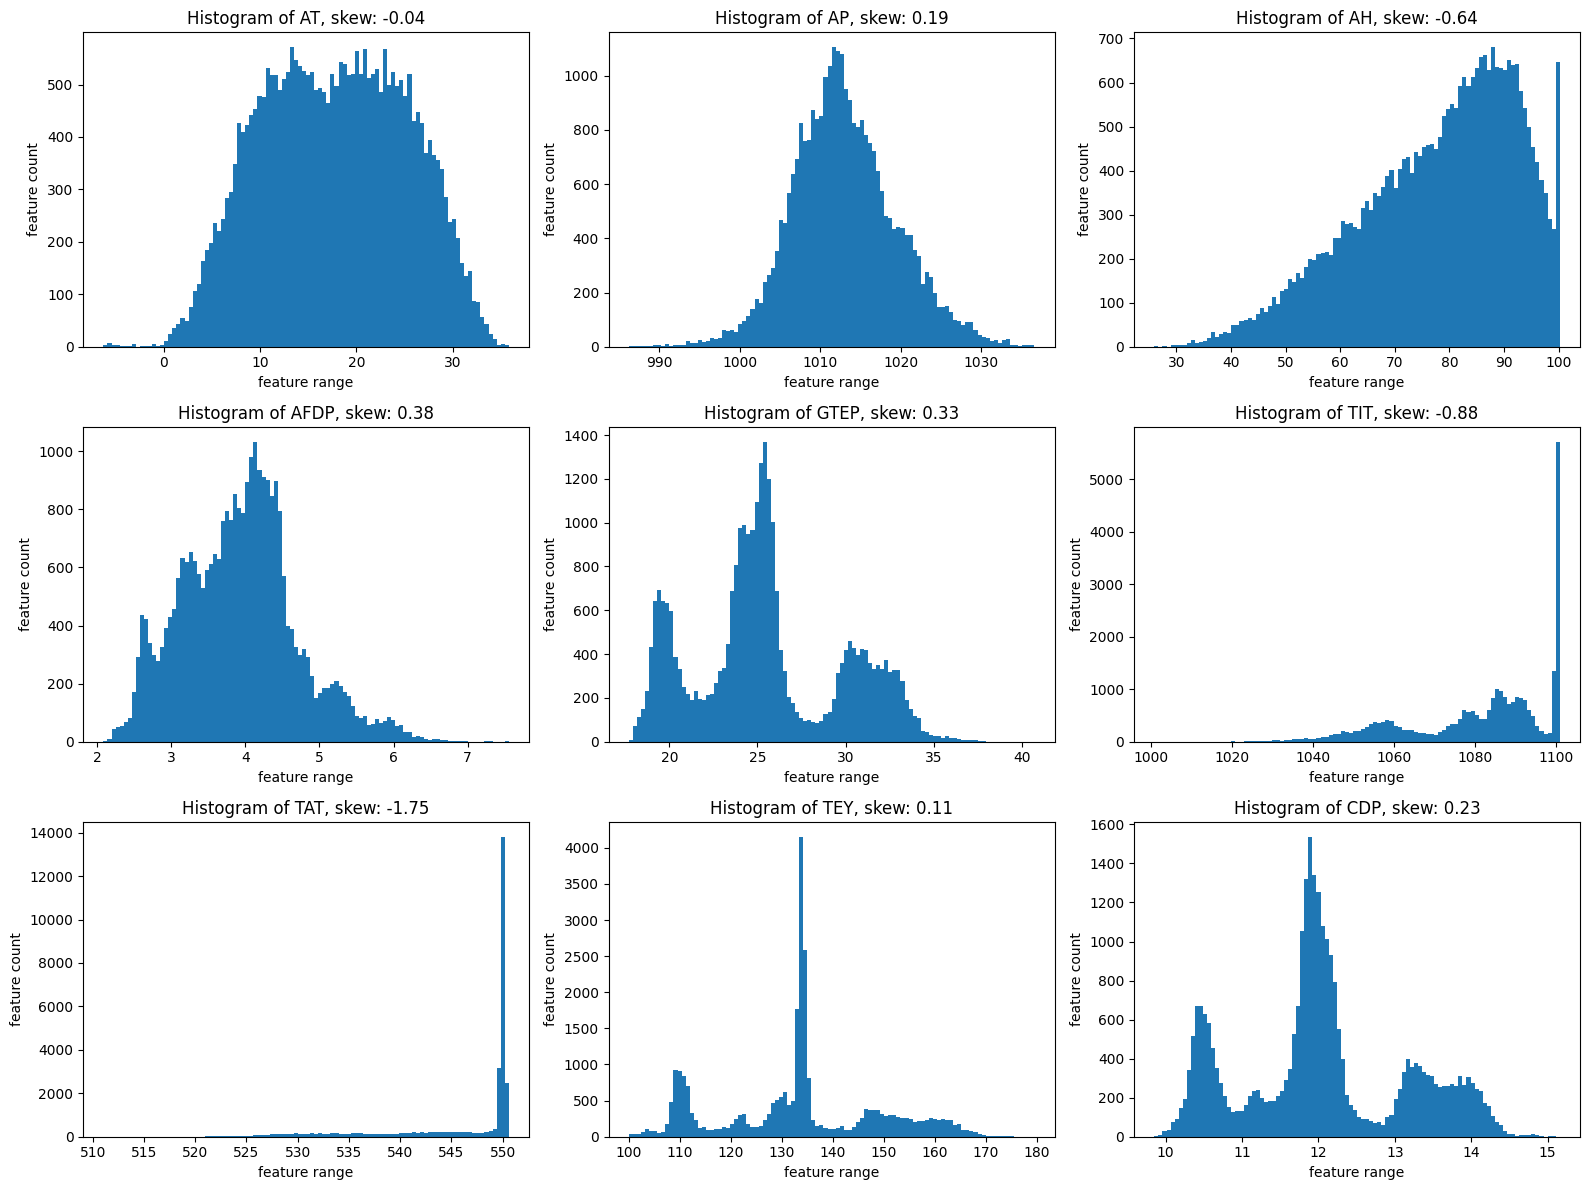

In [81]:
def plot_numerical(plot_df: pd.DataFrame):
    fig, axes = plt.subplots(3, 3, figsize=(16, 12))
    flat_axes = axes.flatten()
    numeric_features = [f for f in plot_df.columns if f not in ['NOX', 'year']]

    for ax, f_name in zip(flat_axes, numeric_features):
        ax.hist(plot_df[f_name], bins=100)
        ax.set(xlabel='feature range', ylabel='feature count',
               title=f'Histogram of {f_name}, skew: {plot_df[f_name].skew():.2f}')

    fig.tight_layout()


plot_numerical(t_data_df)

### What preprocessing can be done if the distribution of a feature has high skewness?
Depending on the distribution we can apply transforms such as the natural or base 10 logarithm, square root, reflection, Box-Cox and more. Some example transforms are applied below.

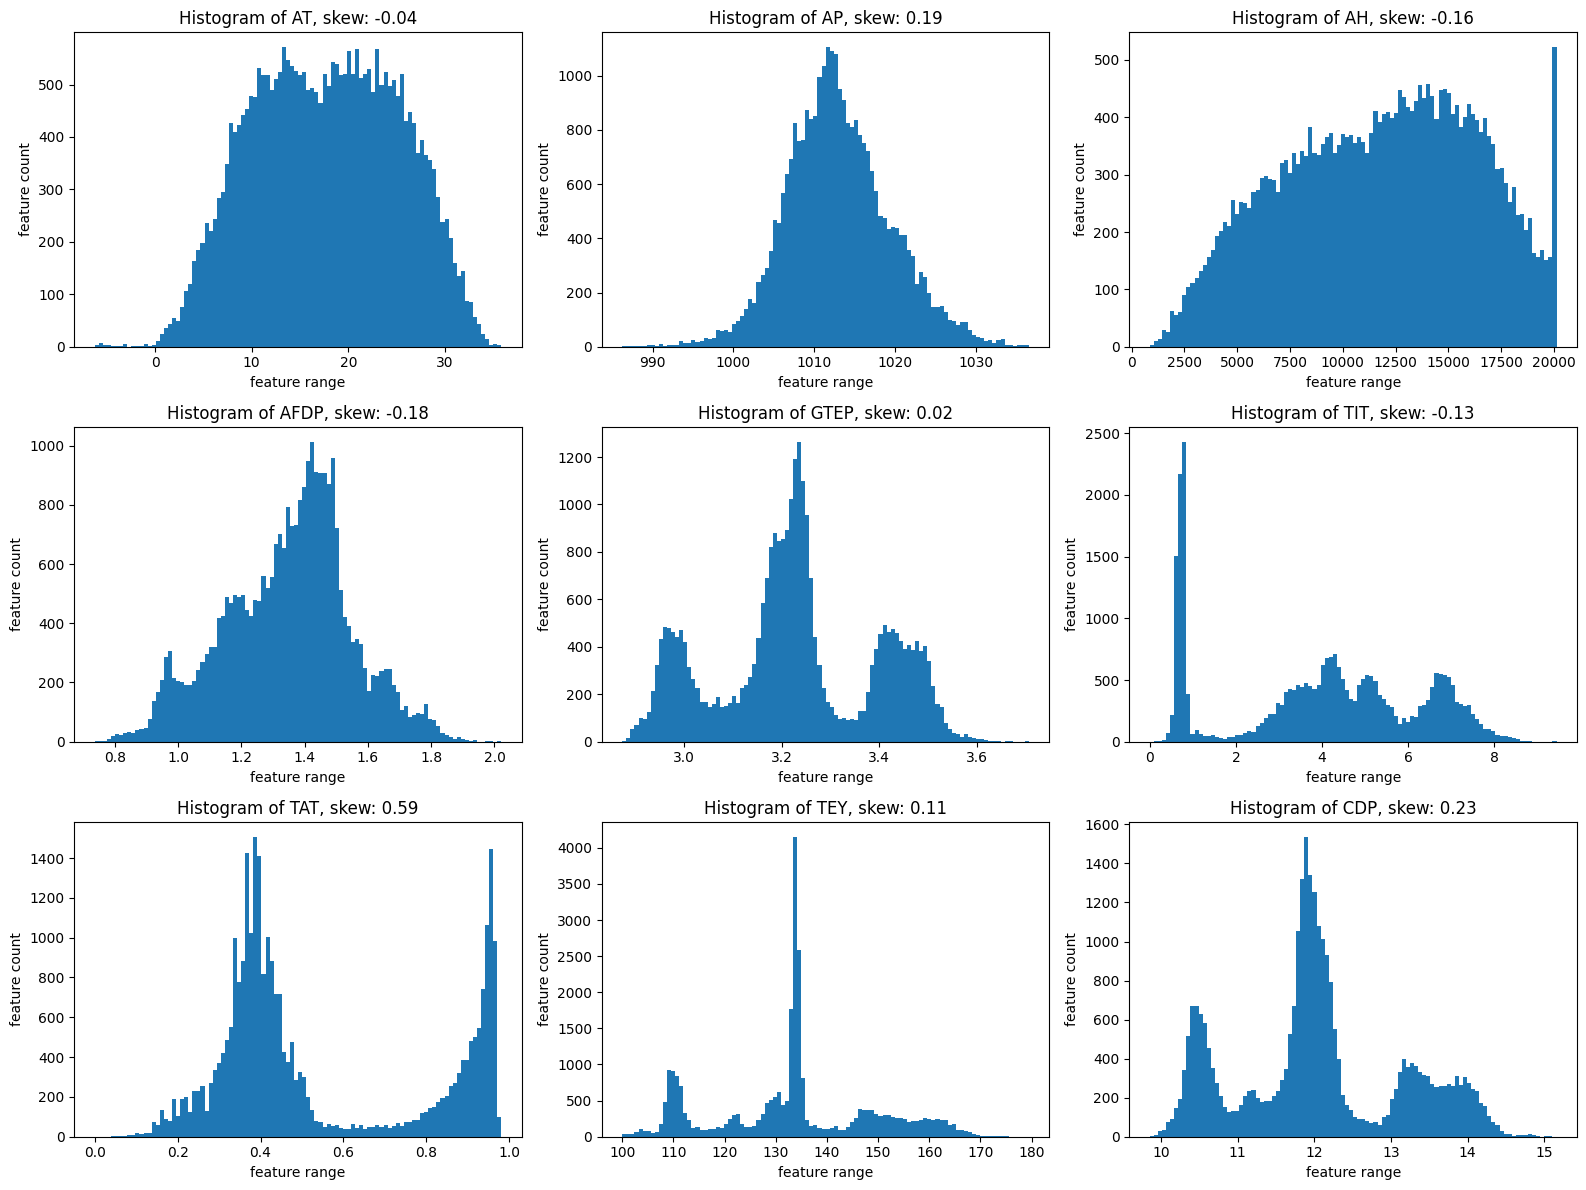

In [82]:
def preprocess(df: pd.DataFrame, params=None):
    deskewed_df = df.copy(deep=True)
    if params:
        deskewed_df['AH'] = stats.boxcox(df['AH'], lmbda=params['AH'])[0]
        deskewed_df['TIT'] = stats.boxcox(np.max(df['TIT']) + 1 - df['TIT'], lmbda=params['TIT'])[
            0]  # Reflect first for positive skew, then apply boxcox transform
        deskewed_df['TAT'] = stats.boxcox(np.max(df['TAT']) + 1 - df['TAT'], lmbda=params['TAT'])[
            0]  # Reflect first for positive skew, then apply boxcox transform
    else:
        params = {}
        deskewed_df['AH'], params['AH'] = stats.boxcox(df['AH'])
        deskewed_df['TIT'], params['TIT'] = stats.boxcox(
            np.max(df['TIT']) + 1 - df['TIT'])  # Reflect first for positive skew, then apply boxcox transform
        deskewed_df['TAT'], params['TAT'] = stats.boxcox(
            np.max(df['TAT']) + 1 - df['TAT'])  # Reflect first for positive skew, then apply boxcox transform
    deskewed_df['AFDP'] = np.log(df['AFDP'])
    deskewed_df['GTEP'] = np.log(df['GTEP'])

    return deskewed_df, params


deskewed_train_X, preprocess_params = preprocess(train_X)
deskewed_test_X, _ = preprocess(test_X, preprocess_params)
plot_numerical(deskewed_train_X)

## Categorical Features
We only have "year" here.

Text(0.5, 1.0, 'Categorical Feature - Year')

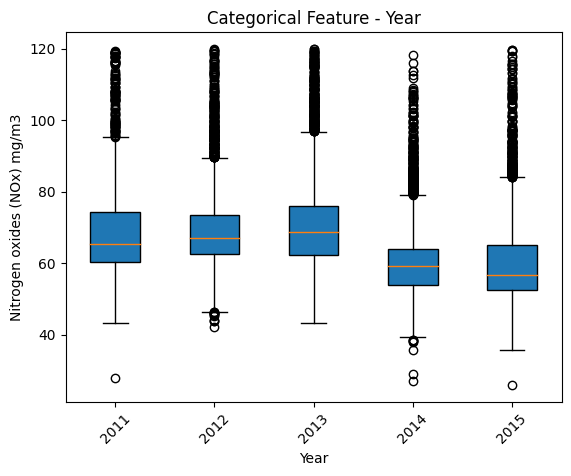

In [83]:
# Creating plot
plot_labels = np.unique(t_data_df['year'])
nox_by_year = [t_data_df[t_data_df['year'] == p]['NOX'] for p in plot_labels]
box_count = len(plot_labels)
box_width = 0.5
box_spacing = 3
bplot1 = plt.boxplot(nox_by_year, patch_artist=True)
plt.ylabel('Nitrogen oxides (NOx) mg/m3')
plt.xlabel('Year')
ticks = np.arange(box_count) + 1
plt.xticks(ticks, plot_labels)
plt.xticks(rotation=45)
plt.title(f'Categorical Feature - Year')

We can generally observe the that Nitrogen oxide are distributed similarly per year, although there is a slight dip for 2014 and 2015. Also all years seem to have timesteps when there are considerably higher outliers.

## Yearly Trends


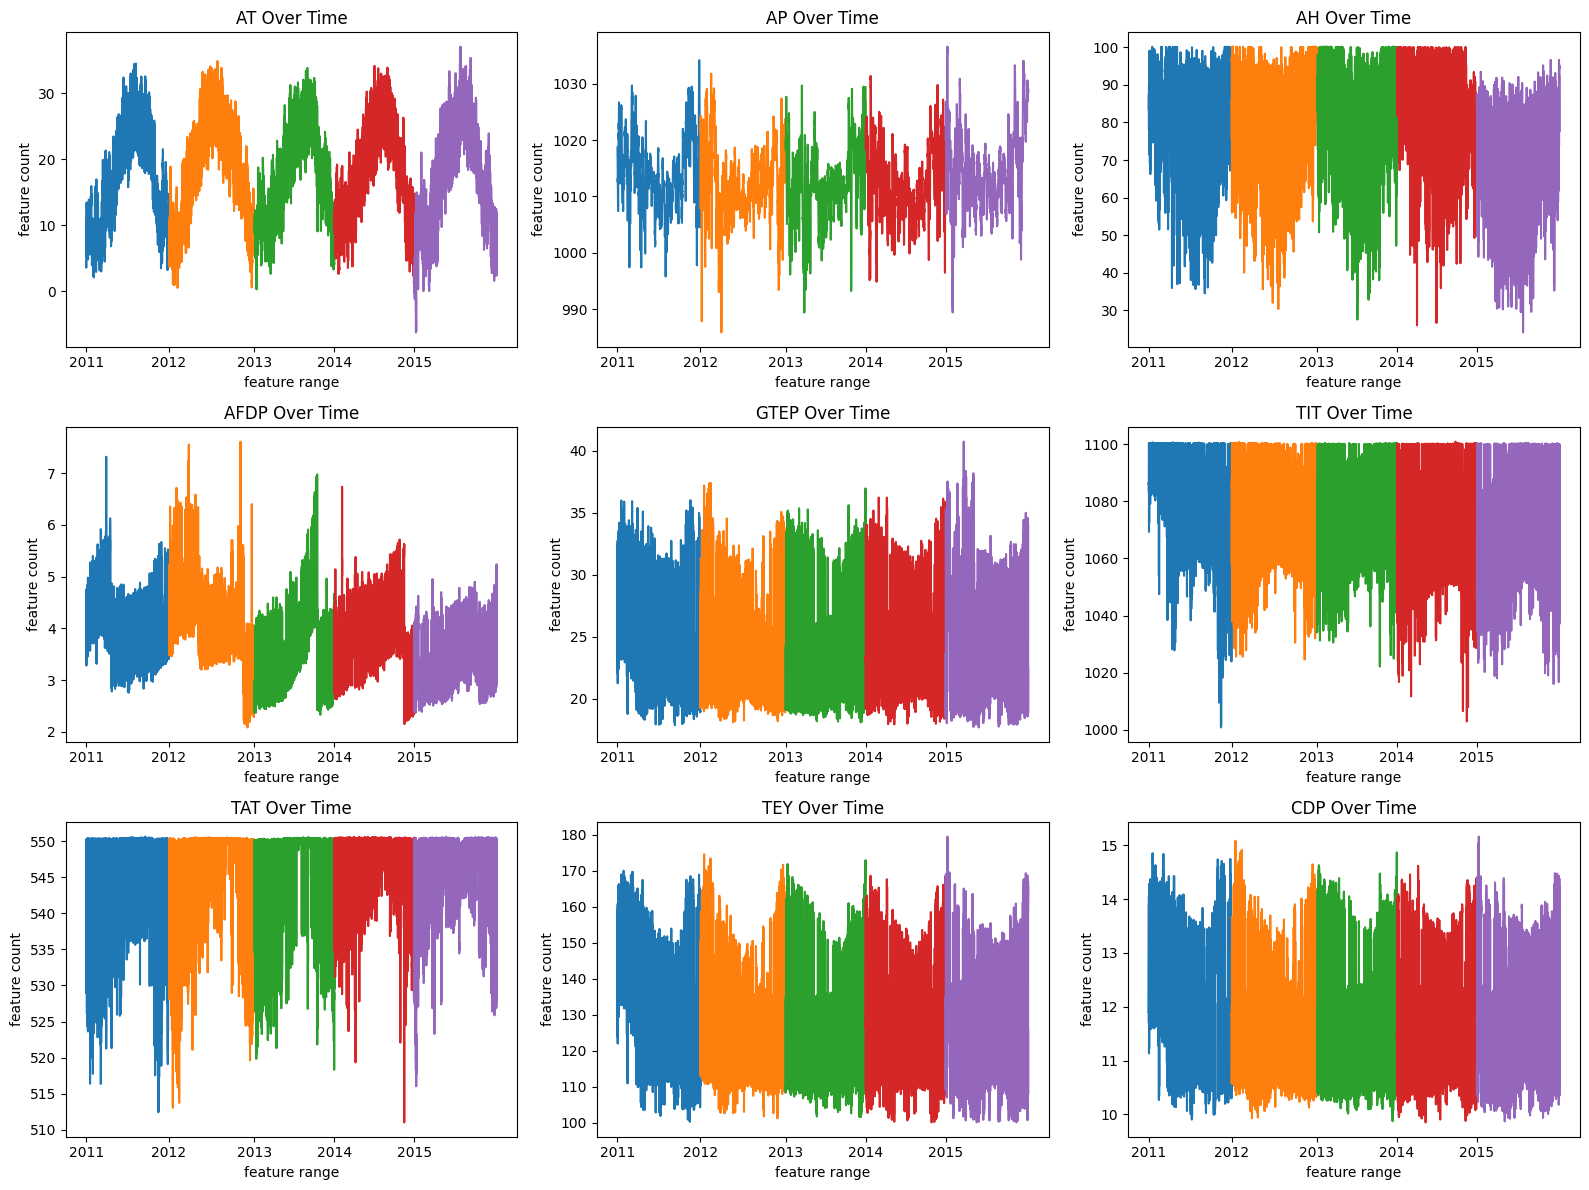

In [84]:
def plot_yearly(plot_df: pd.DataFrame):
    fig, axes = plt.subplots(3, 3, figsize=(16, 12))
    flat_axes = axes.flatten()
    numeric_features = [f for f in plot_df.columns if f not in ['NOX', 'year']]
    plot_labels, label_counts = np.unique(plot_df['year'], return_counts=True)
    ticks = np.cumsum(np.concatenate(([0], label_counts)))[:-1]  # Some extra magic to move the years to the start

    for ax, f_name in zip(flat_axes, numeric_features):
        f_by_year = [plot_df[plot_df['year'] == p][f_name] for p in plot_labels]
        for d in f_by_year:
            ax.plot(d)
        ax.set(xlabel='feature range', ylabel='feature count', title=f'{f_name} Over Time')
        ax.set_xticks(ticks, plot_labels)

    fig.tight_layout()


plot_yearly(data_df)

We can observe that our most correlated feature Ambient Temperature (AT) is fairly consistent year over year, which makes sense as this is ultimately just data on the climate. Similar observations can be made on AP, TIT, TEY, GTEP and CDP. AH is slightly decreasing year over year, whereas TAT is slightly increasing. AFDP appears to be notably decreasing over the years.

# Question 2

## Standardisation

In [85]:
scaler = StandardScaler()
z_train_X_df = pd.DataFrame(scaler.fit_transform(deskewed_train_X), columns=deskewed_train_X.columns)
z_test_X_df = pd.DataFrame(scaler.transform(deskewed_test_X), columns=deskewed_test_X.columns)
z_train_X_df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,year
0,-0.981516,2.464441,-0.201635,2.113852,1.699988,-1.534620,1.631693,1.798999,1.936252,-0.696048
1,0.395871,-0.129644,1.059529,-0.276612,-1.519446,1.243112,-0.379273,-1.525560,-1.405476,-0.696048
2,0.260461,0.367426,1.112917,-0.664160,-1.094374,1.260078,-1.249467,-1.305331,-1.147502,0.717502
3,1.599218,-1.015050,-1.250973,1.098892,1.161616,-1.446177,1.450337,0.959057,1.026458,-0.696048
4,0.104188,0.491694,0.787164,0.216140,1.342971,-1.446177,1.531364,1.180566,1.275251,0.010727


## Feature Selection

In [86]:
mi_preprocessed = mutual_info_regression(z_train_X_df, train_Y)
f_preprocessed = f_regression(z_train_X_df, train_Y)

d = {
    'feature_names': z_train_X_df.columns,
    'mi_preprocessed': mi_preprocessed,
    'f_preprocessed_F': f_preprocessed[0],
    'f_preprocessed_p_val': f_preprocessed[1]
}
results_df = pd.DataFrame.from_dict(d)
display(results_df)

,feature_names,mi_preprocessed,f_preprocessed_F,f_preprocessed_p_val
0,AT,0.270877,13366.654561,0.000000e+00
1,AP,0.096084,1121.622720,2.295699e-241
2,AH,0.042790,807.050768,3.702277e-175
3,AFDP,0.146325,1533.925154,0.000000e+00
4,GTEP,0.253181,1427.685688,4.098868e-305
5,TIT,0.280377,1063.831297,2.959880e-229
6,TAT,0.123580,379.191512,6.317202e-84
7,TEY,0.277037,426.206495,5.063582e-94
8,CDP,0.232185,920.668241,3.746355e-199
9,year,0.139289,2749.184874,0.000000e+00


From the above, we can see that the two features with the lowest MI are AP and AH (this varies based on whether we use all data or the train data). Regarding how many features to select for training, we should consider the following trade-offs per model:

- **Linear regression** - more features should yield lower test RMSE, but too many highly correlated or noisy features will increase it.
- **Polynomial regression** - similar to linear regression, except that it is more prone to overfitting due to the polynomial weights.
- **Neural networks** - able to capture more complex and non-linear relationships with more features, but also prone to overfitting without regularisation, so test and train RMSE may be very different.
- **Random forests** - generally are not as negatively impacted by number of features due to feature bagging, but can still overfit if too many features are irrelevant.

Based on the MI, F-statistic and correlation scores, we will consider the following features (ordered by descending usefulness):

1. AT
2. year
3. AFDP
4. AP
5. AH
6. TAT
7. TIT
8. CDP
9. TEY

A different number will be used depending on the model.

# Question 3

Random forests use bootstrap aggregating (bagging) to sample data for each the decision tree to fit. This works by subsampling the original training data with replacement, while holding some training samples in reserve. The Out-of-Bag Error (OOB) is the average prediction error on the reserve training samples.

The $R^2 \in (-\infty,1]$ score is the coefficient of determination and is given by:

$$
R^2(\textbf{y}, \hat{\textbf{y}}) = 1 - \frac{\sum_{i} (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}
$$

Where $y_i$ is the target value for datapoint $i$, $\hat{y}_i$ is the model prediction for $i$ and $\bar{y}$ is the sample mean of all target values. It measures how well a model fits the data and explains the variance. In the base case where $\hat{y}_i = \bar{y}$ the score is 0. Values higher than that suggest a better fit, where the ideal case of $1$ would occur if there is no prediction error and the numerator is 0. In the context of random forests, the referenced code calculates the OOB score by getting the average $R^2$ for the reserved training samples. The OOB error is then given by $1 - oob\_score$.

# Question 4

### What is the objective function?

Conventionally we use ordinary least-squares for linear regression, so it is given by:

$$
J(\theta) = \min_\theta \frac{1}{2n} \|\theta - \textbf{Y} \|_2^2 \\
\textbf{X}\in \mathbb{R}^{n \times m},\quad \theta \in \mathbb{R}^{m},\quad \textbf{Y}\in \mathbb{R}^{n}
$$

Where $J$ is the error minimisation objective, $\textbf{X}$ is the feature matrix comprised of $n$ rows of data and $m$ columns of features, $\theta$ are the trainable parameters and $\textbf{Y}$ are the target values.

In [87]:
# Select features
minimal_features = ['AT']
few_features = ['AT', 'year', 'AFDP']
many_features = ['AT', 'year', 'AFDP', 'AP', 'AH', 'TAT']
feature_sets = [minimal_features, few_features, many_features]
results = {'scores': [], 'searches': []}


def rmse(estimator, X, y):
    # This is set to negative so the grid search correctly identifies the better score.
    return -np.sqrt(mean_squared_error(y, estimator.predict(X), squared=False))


def recursive_search_parameters(estimator, X: np.ndarray, y: np.ndarray, params: dict, search_param: str, depth: int,
                                max_depth: int, verbose=False):
    search_range = params[search_param]
    if verbose:
        print(f'depth: {depth}/{max_depth}, range: [{search_range[0]}, {search_range[-1]}]')
    search = GridSearchCV(estimator, params, scoring=rmse, return_train_score=True, cv=10, n_jobs=8)
    search.fit(X, y)
    a = np.argsort(np.abs(search.cv_results_['mean_test_score']))  # Take abs as our RMSEs are negative
    next_start_idx, next_end_idx = a[:2]
    next_params = params | {search_param: np.linspace(search_range[next_start_idx], search_range[next_end_idx], 20)}
    next_depth = depth + 1
    if next_depth > max_depth:
        return search
    else:
        return recursive_search_parameters(estimator, X, y, next_params, search_param, next_depth, max_depth, verbose)


# Train models
for feature_set in feature_sets:
    s_train_X_df = z_train_X_df[feature_set]
    s_test_X_df = z_test_X_df[feature_set]

    linear_reg = LinearRegression()
    linear_reg_search = GridSearchCV(linear_reg, {'fit_intercept': [True]}, scoring=rmse, return_train_score=True,
                                     cv=10, n_jobs=8)
    linear_reg_search.fit(s_train_X_df, train_Y)
    best_base_idx = np.where(linear_reg_search.cv_results_['rank_test_score'] == 1)[0][0]
    train_score_base = linear_reg_search.cv_results_['mean_train_score'][best_base_idx]
    val_score_base = linear_reg_search.cv_results_['mean_test_score'][best_base_idx]
    test_score_base = rmse(linear_reg_search.best_estimator_, s_test_X_df, test_Y)

    linear_reg_l1_params = {'alpha': np.linspace(1e-10, 1e2, 100), 'max_iter': [5000]}
    linear_reg_l1 = Lasso()
    linear_reg_l1_search = recursive_search_parameters(linear_reg_l1, s_train_X_df, train_Y, linear_reg_l1_params,
                                                       'alpha', 0, 10)
    best_l1_idx = np.where(linear_reg_l1_search.cv_results_['rank_test_score'] == 1)[0][0]
    train_score_l1 = linear_reg_l1_search.cv_results_['mean_train_score'][best_l1_idx]
    val_score_l1 = linear_reg_l1_search.cv_results_['mean_test_score'][best_l1_idx]
    test_score_l1 = rmse(linear_reg_l1_search.best_estimator_, s_test_X_df, test_Y)

    linear_reg_l2_params = {'alpha': np.linspace(1e-10, 1e2, 100), 'max_iter': [5000]}
    linear_reg_l2 = Ridge()
    linear_reg_l2_search = recursive_search_parameters(linear_reg_l2, s_train_X_df, train_Y, linear_reg_l1_params,
                                                       'alpha', 0, 10)
    best_l2_idx = np.where(linear_reg_l2_search.cv_results_['rank_test_score'] == 1)[0][0]
    train_score_l2 = linear_reg_l2_search.cv_results_['mean_train_score'][best_l2_idx]
    val_score_l2 = linear_reg_l2_search.cv_results_['mean_test_score'][best_l2_idx]
    test_score_l2 = rmse(linear_reg_l2_search.best_estimator_, s_test_X_df, test_Y)

    results['scores'].append([[train_score_base, val_score_base, test_score_base],
                              [train_score_l1, val_score_l1, test_score_l1],
                              [train_score_l2, val_score_l2, test_score_l2]])
    results['searches'].append([linear_reg_search, linear_reg_l1_search, linear_reg_l2_search])

In [88]:
names = ['Linear regression', 'Linear regression L1', 'Linear regression L2']

for feature_set, scores in zip(feature_sets, results['scores']):
    print(f'\nWith features: {feature_set}:')
    for n, s in zip(names, scores):
        print(f"{n} train error: {s[0]:.3f}")
        print(f"{n} validation error: {s[1]:.3f}")
        print(f"{n} test error: {s[2]:.3f}")


With features: ['AT']:
Linear regression train error: -3.117
Linear regression validation error: -3.117
Linear regression test error: -3.096
Linear regression L1 train error: -3.117
Linear regression L1 validation error: -3.117
Linear regression L1 test error: -3.096
Linear regression L2 train error: -3.117
Linear regression L2 validation error: -3.117
Linear regression L2 test error: -3.096

With features: ['AT', 'year', 'AFDP']:
Linear regression train error: -2.987
Linear regression validation error: -2.987
Linear regression test error: -2.973
Linear regression L1 train error: -2.987
Linear regression L1 validation error: -2.987
Linear regression L1 test error: -2.973
Linear regression L2 train error: -2.987
Linear regression L2 validation error: -2.987
Linear regression L2 test error: -2.973

With features: ['AT', 'year', 'AFDP', 'AP', 'AH', 'TAT']:
Linear regression train error: -2.929
Linear regression validation error: -2.929
Linear regression test error: -3.006
Linear regressi

As the ['AT', 'year', 'AFDP'] feature set seems to do best, we'll use this one for subsequent questions. Note also that the negative RMSE is used as the GridSearchCV picks the highest score (i.e lowest error when negative).

## Effect of each regularization scheme on the learned parameter set


In [89]:
searches = results['searches'][1]
for s, n in zip(searches, names):
    print(f'{n} parameters:')
    print(s.best_estimator_.coef_)

Linear regression parameters:
[-6.02302736 -3.91082747 -1.86776442]
Linear regression L1 parameters:
[-6.02114596 -3.90715489 -1.86454719]
Linear regression L2 parameters:
[-6.01876125 -3.90761625 -1.86676865]


The regularisation scheme doesn't have much of an impact. We expect that the parameters will be smaller for L1 and L2 regularisations than for the base linear regression, which they are, but not by a significant amount.

## Choice of the best regularization scheme along with the optimal penalty
The best regularisation scheme appears to be L2 regularisation. The penalty hyperparameter $\alpha$ was computed by performing a recursive search over increasingly smaller intervals. See below for an example output (the last interval also has the optimal $\alpha$).

In [90]:
s_train_X_df = z_train_X_df[feature_sets[1]]
linear_reg_l2_params = {'alpha': np.linspace(1e-10, 1e2, 100), 'max_iter': [5000]}
linear_reg_l2 = Ridge()
_ = recursive_search_parameters(linear_reg_l2, s_train_X_df, train_Y, linear_reg_l2_params, 'alpha', 0, 5, True)

depth: 0/5, range: [1e-10, 100.0]
depth: 1/5, range: [22.2222222223, 21.2121212122]
depth: 2/5, range: [22.2222222223, 22.169059011242105]
depth: 3/5, range: [22.199837712380887, 22.197039648641]
depth: 4/5, range: [22.198954113305135, 22.198512313767257]
depth: 5/5, range: [22.198954113305135, 22.198582071589026]


## Does feature standardization play a role in improving the model performance (in the cases with ridge regularization)?
Let's compare with/without:

In [15]:
# Without
s_train_X_df = train_X[feature_sets[1]]
s_test_X_df = test_X[feature_sets[1]]
linear_reg_l2_params = {'alpha': np.linspace(1e-10, 1e3, 100), 'max_iter': [5000]}
linear_reg_l2 = Ridge()
linear_reg_l2_search = recursive_search_parameters(linear_reg_l2, s_train_X_df, train_Y, linear_reg_l2_params, 'alpha',
                                                   0, 5, True)
best_l2_idx = np.where(linear_reg_l2_search.cv_results_['rank_test_score'] == 1)[0][0]
train_score_l2 = linear_reg_l2_search.cv_results_['mean_train_score'][best_l2_idx]
val_score_l2 = linear_reg_l2_search.cv_results_['mean_test_score'][best_l2_idx]
test_score_l2 = rmse(linear_reg_l2_search.best_estimator_, s_test_X_df, test_Y)
print(f"{names[2]} train error: {train_score_l2:.3f}")
print(f"{names[2]} validation error: {val_score_l2:.3f}")
print(f"{names[2]} test error: {test_score_l2:.3f}")
print(f"parameters:")
print(linear_reg_l2_search.best_estimator_.coef_)

depth: 0/5, range: [1e-10, 1000.0]
depth: 1/5, range: [60.60606060615454, 70.70707070716362]
depth: 2/5, range: [63.795853269631095, 64.32748538021052]
depth: 3/5, range: [63.879795181827845, 63.907775819226764]
depth: 4/5, range: [63.89452183309044, 63.8886311725854]
depth: 5/5, range: [63.890181346402514, 63.89359172880017]
Linear regression L2 train error: -2.993
Linear regression L2 validation error: -2.993
Linear regression L2 test error: -2.979
parameters:
[-0.82691822 -2.71757902 -2.08378762]


Applying linear regression with L2 regularisation does yield a slightly worse performance if the model isn't standardised, but not by much. This is likely due to the fact that the ['AT', 'year', 'AFDP'] features are already distributed quite similarly to Gaussians (they have low skew) so they don't change significantly in shape when standardised. The model then just accounts for the larger input ranges by using lower weights and a bigger $\alpha$ penalty.

## What is the meaning of these p-values and how can you infer the most significant features?

The $p$-value is the probability of obtaining training data that is as least as statistically extreme as our actual training data, under the assumption that some null hypothesis is true. In the context of `scipy.stats.linregress` the null hypothesis is that the regression has a slope of 0 (i.e the prediction is constant with regard to the input and there is no relationship). If the $p$-value falls below some threshold of statistical significance (e.g 0.01) we can reject the null-hypothesis and consider that the features are likelier to support the alternative hypothesis (the slope is non-negative). We can rank features from lowest to highest p-value to order them by increasing significance, though it should be noted that this is not provide a full picture and other factors such as the effect size (coefficient magnitude) should also be considered to decide how important a feature is. Below is a listing of the p-values for some features:

In [16]:
for i, f_name in enumerate(feature_sets[2]):
    print(f'Feature {f_name}')
    result = linregress(z_train_X_df.to_numpy()[:, i], train_Y.to_numpy())
    print(f'P-val: {result.pvalue}')

Feature AT
P-val: 0.0
Feature year
P-val: 2.2956994122976057e-241
Feature AFDP
P-val: 3.702277126804789e-175
Feature AP
P-val: 0.0
Feature AH
P-val: 4.0988678114466326e-305
Feature TAT
P-val: 2.9598802514114254e-229


# Question 5

In [17]:
poly_degrees = [1, 2, 3, 4, 5, 6]
# Generates list of all possible ascending tuple pairs. E.g [(1,2), (1,3), ... (5,6)]
poly_pairings = sorted([(j, i) for i in poly_degrees for j in range(1, i)])
poly_reg = Ridge()

cache_dir = 'q5_pipeline_cache'
pipe = Pipeline(steps=[('poly_features', PolynomialFeatures()),
                       ('standardisation', StandardScaler()),
                       ('regression', Ridge())], memory=cache_dir)

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'poly_features__degree': poly_pairings,
    'regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 5, 10, 20, 40],
}

features = feature_sets[1]


def run_train():
    print(f'Searching using features {features}')
    search = GridSearchCV(pipe, param_grid, scoring=rmse, return_train_score=True, cv=10, n_jobs=8, verbose=1)
    search.fit(deskewed_train_X[features], train_Y)
    return search


start = time.time()
search_result = filter_parallel_warnings(run_train)
end = time.time()
print(f'Took {(end - start) / 60:.2}min')

Searching using features ['AT', 'year', 'AFDP']
Fitting 10 folds for each of 135 candidates, totalling 1350 fits
Took 1.2min


In [18]:
c = search_result.cv_results_
e = search_result.best_estimator_
print(f'Top result:')
rank_idx = np.where(search_result.cv_results_['rank_test_score'] == 1)[0][0]
test_score = rmse(e, deskewed_test_X[features], test_Y)
print(f"params: {c['params'][rank_idx]}")
print(f"train error: {c['mean_train_score'][rank_idx]:.3f}")
print(f"validation error: {c['mean_test_score'][rank_idx]:.3f}")
print(f"test error: {test_score:.3f}")

Top result:
params: {'poly_features__degree': (1, 6), 'regression__alpha': 0.0001}
train error: -2.752
validation error: -2.753
test error: -2.754


## What are the most salient features? Why?

If we assume we can determine saliency by comparing coefficient magnitudes or correlation, then this is given below. However, it should be noted that as we have 84 features for 6-degree polynomial, analysis is difficult. A higher magnitude coefficient isn't necessarily more salient as there could exist another similarly high coefficient that it strongly negatively correlates with, that cancels it out. This actually must be the case because our highest coefficients are in the (-2000,2020) range (see below), whereas our target variable's min-max range is (24,120). This is also due to the grid-search choosing a low $\alpha$ which appears to yield a lower RMSE.

For this reason we will rather consider features that correlate strongly with the target variable (see below as well). There we can observe that combinations with "AT" appear to correlate best, which makes sense as this is the most correlated feature originally.

In [19]:
feature_names = e.named_steps['poly_features'].feature_names_in_
powers = e.named_steps['poly_features'].powers_
# Generates feature names with respective powers
powered_feature_names = ['*'.join([f'{n}^{p}' for n, p in zip(feature_names, f_pows) if p > 0])
                         for f_pows in powers]
k = 10
highest_mag_coeffs_idcs = np.argsort(np.abs(e.named_steps['regression'].coef_))[-k:]
print(f'Top {k} most weighted features:')
for i in range(k):
    c_idx = highest_mag_coeffs_idcs[i]
    w = e.named_steps['regression'].coef_[c_idx]
    f_name = powered_feature_names[c_idx]
    print(f'{f_name}: {w:.2f}')

# Get features
all_poly_features = search_result.best_estimator_[:-1].transform(deskewed_train_X[features])

print(f'\nTop {k} most correlated features:')
correlations = np.array([pearsonr(x, train_Y)[0] for x in all_poly_features.T])
correlations = correlations[~np.isnan(correlations)]
highest_correlated_features_idcs = np.argsort(np.abs(correlations))[-k:]
for i in range(k):
    c_idx = highest_correlated_features_idcs[i]
    c = correlations[c_idx]
    f_name = powered_feature_names[c_idx]
    print(f'{f_name}: {c:.2f}')

print(f'\nElements in common: {set(highest_mag_coeffs_idcs).intersection(highest_correlated_features_idcs)}')

Top 10 most weighted features:
AT^2*AFDP^2: 1048.99
year^2*AFDP^3: 1194.97
year^2*AFDP^4: 1275.27
AFDP^1: 1322.09
AFDP^5: -1355.02
AT^3*AFDP^2: 1488.14
year^5*AFDP^1: -1524.42
AT^2*year^1*AFDP^3: -1660.65
AFDP^4: -1961.35
year^3*AFDP^3: 2018.53

Top 10 most correlated features:
AT^1*year^2: -0.52
AT^1*year^3: -0.52
AT^1*year^4: -0.52
AT^1*year^5: -0.53
: -0.56
AT^2: -0.56
AT^2*AFDP^1: -0.56
AT^2*AFDP^2: -0.56
AT^2*AFDP^3: -0.56
AT^2*AFDP^4: -0.56

Elements in common: {25}


## Optimal degree and fit

### What degree of polynomial is best? How did you find the optimal degree?
We found the optimal degree by performing a gridsearch on various $\alpha$ values and all possible min-max degree tuples (i.e from $(1,2),(1,3)...(5,6)$. In our case the best degree of polynomials is 6, but this is also due to only using 3 features. More features would likely require a lower degree polynomial to avoid overfitting.

### What does a very high-order polynomial imply about the fit on the training data? What about its performance on testing data?

A high degree polynomial is very much inclined to overfit to noise in the training data, which can yield a significant degradation in test performance. However, in our case we appear to have picked features that are distinct enough that this did not happen and the performance on the unseen test data is more or less the same (see earlier grid-search results).

# Question 6

## Optimise NN on limited budget

In [20]:
features = feature_sets[1]

layer_sizes =  [[32]*k for k in range(1,4)]

alphas = list(reversed([0.001, 0.01, 0.1]))

regressor = MLPRegressor(max_iter=5000,
                         random_state=seed,
                         early_stopping=True)

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'hidden_layer_sizes': layer_sizes,
    'alpha': alphas,
}
print(f'Parameters to explore: {param_grid}')

def run_train():
    print(f'Searching using features {features}')
    search = GridSearchCV(regressor, param_grid, scoring=rmse, return_train_score=True, cv=10, n_jobs=8, verbose=1)
    search.fit(z_train_X_df[features], train_Y)
    return search

start = time.time()
search = filter_parallel_warnings(run_train)
end = time.time()
print(f'Took {(end - start) / 60:.2f}min')

Parameters to explore: {'hidden_layer_sizes': [[32], [32, 32], [32, 32, 32]], 'alpha': [0.1, 0.01, 0.001]}
Searching using features ['AT', 'year', 'AFDP']
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Took 9.54min


In [21]:
c = search.cv_results_
e = search.best_estimator_
print(f'Top result:')
rank_idx = np.where(search.cv_results_['rank_test_score'] == 1)[0][0]
test_score = rmse(e, z_test_X_df[features], test_Y)
print(f"params: {c['params'][rank_idx]}")
print(f"train error: {c['mean_train_score'][rank_idx]:.3f}")
print(f"validation error: {c['mean_test_score'][rank_idx]:.3f}")
print(f"test error: {test_score:.3f}")

Top result:
params: {'alpha': 0.01, 'hidden_layer_sizes': [32, 32, 32]}
train error: -2.564
validation error: -2.571
test error: -2.584


## Performance vs. Linear Regression

The neural network performs better than the linear regression. This is because neural networks are also able to capture non-linear relationships between features, allowing for a better fit.

## Output Activation Function

No activation function is used for the output layer as we usually want regression models to be able to output any real value. In the case of NOX target variable (which ranges from (25,120 in our data), we could in theory use ReLU as a negative nitrogen oxide level cannot exist anyway. In practice, it does not significantly change the performance.

## The risk of increasing the depth of the network

If we increase the network depth too much, we risk overfitting on the training data. Also the network becomes harder to train due to vanishing or exploding gradients and the computational cost overall increases as well.

# Question 7

In [71]:
regressor = RandomForestRegressor(random_state=seed, oob_score=True)
features = feature_sets[2]

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'n_estimators': [1600],
    'criterion': ['friedman_mse', 'squared_error'],
    'max_features': list(range(2,len(features) // 2 + 1)),
    'max_depth': list(range(2,len(features) - 1))
}
print(f'Parameters to explore: {param_grid}')

def run_train():
    print(f'Searching using features {features}')
    search = GridSearchCV(regressor, param_grid, scoring=rmse, return_train_score=True, cv=10, n_jobs=8, verbose=1)
    search.fit(z_train_X_df[features], train_Y)
    return search

start = time.time()
search = filter_parallel_warnings(run_train)
end = time.time()
print(f'Took {(end - start) / 60:.2f}min')

Parameters to explore: {'n_estimators': [1600], 'criterion': ['friedman_mse', 'squared_error'], 'max_features': [2, 3], 'max_depth': [2, 3, 4]}
Searching using features ['AT', 'year', 'AFDP', 'AP', 'AH', 'TAT']
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Took 6.13min


In [72]:
c = search.cv_results_
e = search.best_estimator_
print(f'Top result:')
rank_idx = np.where(search.cv_results_['rank_test_score'] == 1)[0][0]
test_score = rmse(e, z_test_X_df[features], test_Y)
print(f"params: {c['params'][rank_idx]}")
print(f"train error: {c['mean_train_score'][rank_idx]:.3f}")
print(f"validation error: {c['mean_test_score'][rank_idx]:.3f}")
print(f"test error: {test_score:.3f}")

Top result:
params: {'criterion': 'friedman_mse', 'max_depth': 4, 'max_features': 3, 'n_estimators': 1600}
train error: -2.690
validation error: -2.699
test error: -2.807


## Hyper-parameters

We can define a random forest's hyper-parameters as follows:

- **Maximum number of features** - controls how many features to consider at maximum whenever we search for a split at a node in a decision tree. A smaller number will yield more diverse nodes and consequently decision trees. This acts as a regulariser by forcing trees to use a more diverse set of features and reduces overfitting.
- **Number of trees** - controls how many decision trees to generate for the random forest. More trees will generally yield a better performance as they can capture more complex relationships in the data. Additionally, the variance of predictions decreases as we average over the predictions of more trees. There is also a regularisation effect as more trees reduce the sensitivity to noise when we randomly bootstrap random samples and features. The only downside is that more trees also require more computation to train.
- **Depth of each tree** - the depth of a tree corresponds to how many decisions a tree can make before predicting the target value. Choosing this variable is a balancing act: too low a depth results in under-fitting on the training data, too high a depth results in over-fitting, which will hurt predictions on the validation and test data.

## Non-linear decision boundary of random forests

The decision boundary of random forests is non-linear for two reasons:

1. In every decision tree we draw a linear decision boundary at a node. However, as we apply this recursively to the previous boundary in order to make a prediction, any node of depth > 1 will yield a non-linear boundary.
2. By using multiple trees in a random forest, we introduce additional non-linearity as now many trees' decision boundaries will overlap within the feature space.

## Example Decision Tree

[Text(0.5, 0.9, 'AT <= -0.1\nfriedman_mse = 136.98\nsamples = 18650\nvalue = 65.29'),
 Text(0.25, 0.7, 'year <= 0.36\nfriedman_mse = 139.0\nsamples = 8693\nvalue = 71.84'),
 Text(0.125, 0.5, 'AFDP <= 0.38\nfriedman_mse = 122.72\nsamples = 5295\nvalue = 75.28'),
 Text(0.0625, 0.3, 'TAT <= -0.05\nfriedman_mse = 142.35\nsamples = 3196\nvalue = 78.35'),
 Text(0.03125, 0.1, 'friedman_mse = 67.34\nsamples = 2021\nvalue = 75.14'),
 Text(0.09375, 0.1, 'friedman_mse = 222.27\nsamples = 1175\nvalue = 83.75'),
 Text(0.1875, 0.3, 'TAT <= 1.5\nfriedman_mse = 57.45\nsamples = 2099\nvalue = 70.65'),
 Text(0.15625, 0.1, 'friedman_mse = 48.19\nsamples = 880\nvalue = 75.65'),
 Text(0.21875, 0.1, 'friedman_mse = 33.25\nsamples = 1219\nvalue = 67.06'),
 Text(0.375, 0.5, 'AT <= -0.92\nfriedman_mse = 116.57\nsamples = 3398\nvalue = 66.41'),
 Text(0.3125, 0.3, 'TAT <= 1.57\nfriedman_mse = 133.62\nsamples = 1521\nvalue = 70.36'),
 Text(0.28125, 0.1, 'friedman_mse = 107.02\nsamples = 1272\nvalue = 72.47'),
 Te

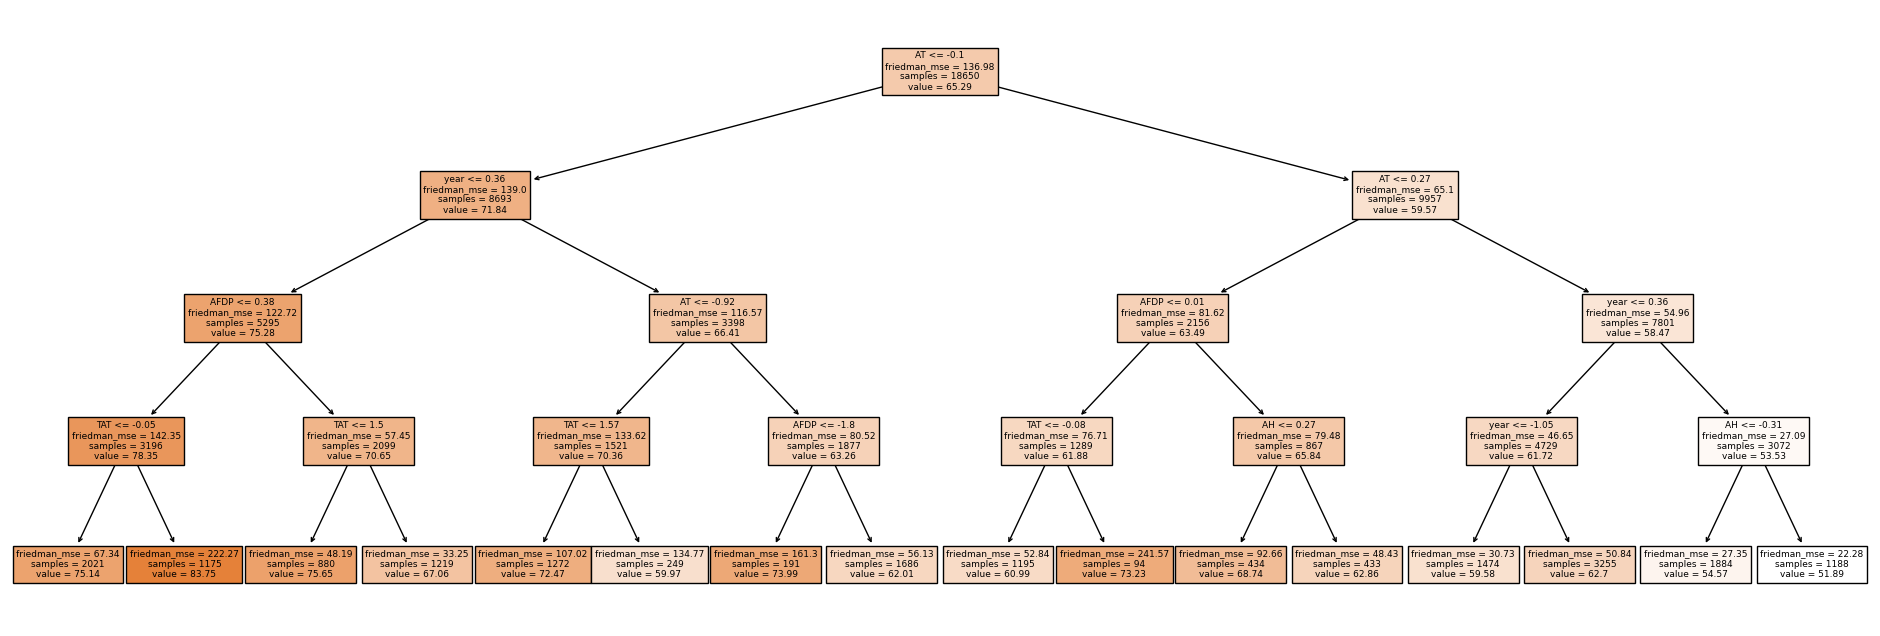

In [76]:
plt.figure(figsize=(24,8))
plot_tree(search.best_estimator_.estimators_[0], precision=2, max_depth=4, filled=True, feature_names=features)


### Which feature is selected for branching at the root node?

It is the "AT" feature.

### What can you infer about the importance of this feature as opposed to others?

That this feature is likely the most important as it used to make the initial boundary on the regression task. Therefore, its value must have a significant impact on the prediction.

### Do the important features correspond to what you got in part 3.3.1?

Mostly, yes, although we use more features for the random forest than the linear regression. Overall though, both seem to treat "year" and "AT" as very important.

## Out-of-bag Error and R2

In [25]:
oob_score = search.best_estimator_.oob_score_
print(f'OOB Score/Avg R2 on training data: {oob_score}')
print(f'OOB Error (training data): {1 - oob_score}')
r2_score = search.best_estimator_.score(z_test_X_df[features], test_Y)
print(f'R2 Score (test data): {r2_score}')

OOB Score/Avg R2 on training data: 0.613023877455561
OOB Error (training data): 0.386976122544439
R2 Score (test data): 0.5312720926409769


The OOB error and R2 of the training data vs. the R2 indicates roughly how the random forest will perform on unseen data. Comparing this to the actual R2 score of the test data we can see it that this indicator is a bit optimistic, possibly due to slight overfitting of the random forest.

# Question 8


## Hyper-parameters

In [26]:
features = feature_sets[2]

# Define the search space for hyperparameters
search_space = {
    'learning_rate': Real(0.0001, 0.005), # affects training speed
    'n_estimators': Integer(50, 200), # number of trees/boosting rounds
    'num_leaves': Integer(2, 40), # max number of leaves allowed in the tree
    'min_data_in_leaf': Integer(30,100),
}

## Bayesian Optimisation

In [27]:
lgb_reg = LGBMRegressor(random_state=seed)

# Create the BayesSearchCV object
search = BayesSearchCV(
    lgb_reg,
    search_space,
    scoring=rmse,
    n_iter=100,
    cv=10,
    n_jobs=-1,
    random_state=seed,
    verbose=0,
    return_train_score=True,
    fit_params= {'callbacks': early_stopping(stopping_rounds=4)}
)

start = time.time()
search.fit(z_train_X_df[features], train_Y)
end = time.time()
print(f'Took {(end - start) / 60:.2f}min')

[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
Took 3.99min


In [28]:
c = search.cv_results_
e = search.best_estimator_
print(f'Top result:')
rank_idx = np.where(search.cv_results_['rank_test_score'] == 1)[0][0]
test_score = rmse(e, z_test_X_df[features], test_Y)
print(f"params: {c['params'][rank_idx]}")
print(f"train error: {c['mean_train_score'][rank_idx]:.3f}")
print(f"validation error: {c['mean_test_score'][rank_idx]:.3f}")
print(f"test error: {test_score:.3f}")

Top result:
params: OrderedDict([('learning_rate', 0.005), ('min_data_in_leaf', 31), ('n_estimators', 200), ('num_leaves', 40)])
train error: -2.653
validation error: -2.670
test error: -2.791


## Effect of Hyper-parameters

We chose 4 hyper-parameters to optimise:

- `learning_rate` - affects fitting efficiency (i.e training speed), but will overfit if set too high.
- `n_estimators` - improves training fitting accuracy by increasing model complexity.
- `num_leaves` - regularises by limiting number of leaf nodes, so the training won't overfit to few samples.
- `min_data_in_leaf` - how many samples must be in leaf at minimum. Also regularises.

It should be noted that it is quite easy to fit more to the training data and still regularise the validation error, but the test error will increase significantly.

# Question 9

In [29]:
def load_tweets(path: str, line_count:Optional[int] = None) -> List[dict]:
    out = []
    counter = 0
    with open(path, 'r') as file:
        for line in file:
            if line_count and counter >= line_count:
                break
            counter += 1
            out.append(json.loads(line))
    return out

base_path = 'ECE219_tweet_data/tweets_'
all_tweet_names =  ['#gohawks', '#gopatriots', '#nfl', '#patriots', '#sb49', '#superbowl']
paths = [f'{base_path}{n}.txt' for n in all_tweet_names]
gohawks_tweets_10 = load_tweets(paths[0], 10)
gopatriots_tweets_10 = load_tweets(paths[1], 10)
nfl_tweets_10 = load_tweets(paths[2], 10)
patriots_tweets_10 = load_tweets(paths[3], 10)
sb49_tweets_10 = load_tweets(paths[4], 10)
superbowl_tweets_10 = load_tweets(paths[5], 10)

## Basic Statistics

In [30]:
def tweets_per_hour(tweets: List[dict]) -> dict:
    local = pytz.timezone("America/Los_Angeles")
    # Group by hour
    hourly_counts = defaultdict(int)
    timestamp_format = '%a %b %d %H:%M:%S %z %Y'

    # Iterate through the timestamps and count occurrences per hour
    for t in tweets:
        created_date_timestamp = t['tweet']['created_at']
        dt = datetime.strptime(created_date_timestamp, timestamp_format)
        dt.astimezone(local)
        hour = dt.replace(minute=0, second=0, microsecond=0)
        hourly_counts[hour] += 1

    return hourly_counts

def average_followers_per_poster(tweets: List[dict]) -> float:
    return np.mean([t['author']['followers'] for t in tweets])

# There's multiple possible metrics for retweets. Went with citations as per recommendation:
# https://piazza.com/class/lcjwqyyip6bid/post/249
def average_retweets_per_tweet(tweets: List[dict]) -> float:
    return np.mean([t['metrics']['citations']['total'] for t in tweets])

def get_statistics(paths: List[str]):
    statistics = defaultdict(list)
    for p in tqdm(paths):
        tweet_data = load_tweets(p)
        statistics['average_tweets_per_hour'].append(np.array(list(tweets_per_hour(tweet_data).values())).mean())
        statistics['average_followers_per_poster'].append(average_followers_per_poster(tweet_data))
        statistics['average_retweets_per_tweet'].append(average_retweets_per_tweet(tweet_data))

    return statistics

In [43]:
statistics = get_statistics(paths)

100%|██████████| 6/6 [04:56<00:00, 49.47s/it]


In [32]:
stats_df = pd.DataFrame.from_dict(statistics, orient='index', columns=all_tweet_names)
display(stats_df)

,#gohawks,#gopatriots,#nfl,#patriots,#sb49,#superbowl
average_tweets_per_hour,251.669643,53.192308,380.133768,665.590634,1384.821229,1996.402961
average_followers_per_poster,2217.923736,1427.252605,4662.375445,3280.463562,10374.160292,8814.967994
average_retweets_per_tweet,2.013209,1.408192,1.534460,1.785287,2.527134,2.391190


## Number of Tweets in Hour

The instructions say to use a bar plot, but we would argue that bucketing the timestamps by hour and then applying a regular line plot is much easier to read.


In [33]:
subset_paths = [f'{base_path}{n}.txt' for n in ['#superbowl', '#nfl']]
superbowl_tweets_per_hour = tweets_per_hour(load_tweets(subset_paths[0]))
nfl_tweets_per_hour = tweets_per_hour(load_tweets(subset_paths[1]))

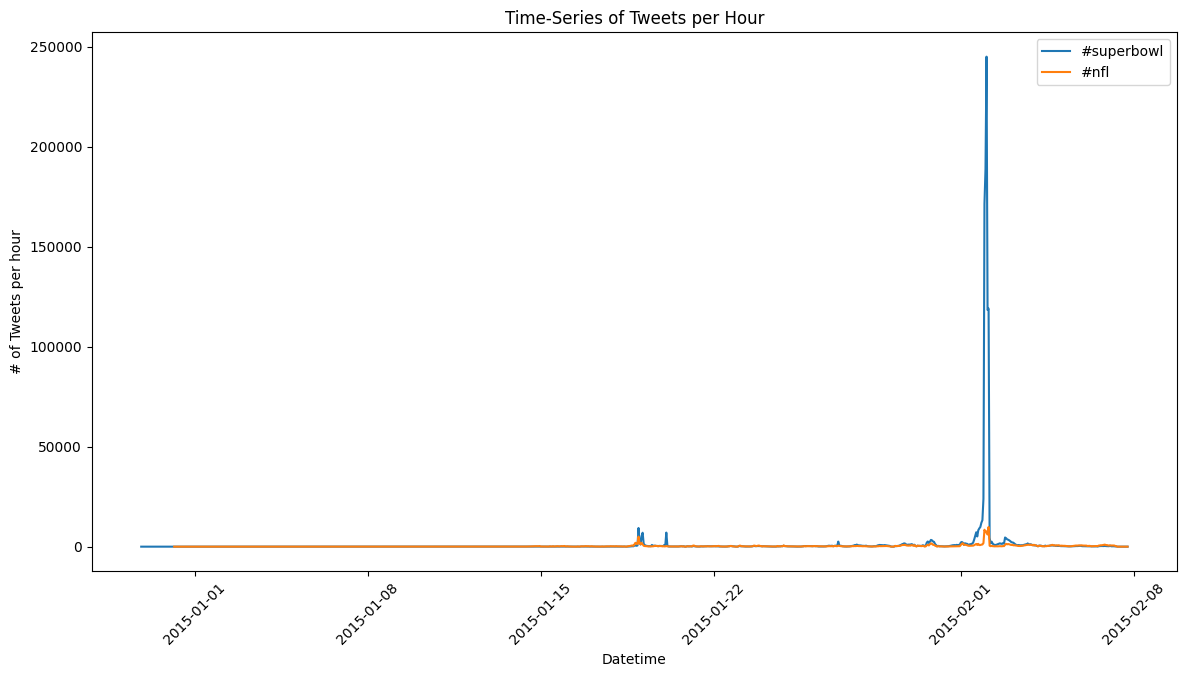

In [34]:
superbowl_tuples = sorted([(k,v) for k,v in superbowl_tweets_per_hour.items()], key=lambda x: x[0])
nfl_tuples = sorted([(k,v) for k,v in nfl_tweets_per_hour.items()], key=lambda x: x[0])

superbowl_timestamps = [k for k,_ in superbowl_tuples]
superbowl_values = [v for _,v in superbowl_tuples]
nfl_timestamps = [k for k,_ in nfl_tuples]
nfl_values = [v for _,v in nfl_tuples]

plt.figure(figsize=(14,7))
plt.plot(superbowl_timestamps, superbowl_values, label='#superbowl')
plt.plot(nfl_timestamps, nfl_values, label='#nfl')
plt.xlabel('Datetime')
plt.ylabel('# of Tweets per hour')
plt.title('Time-Series of Tweets per Hour')
plt.legend()
plt.xticks(rotation=45)

plt.show()

# Question 10

The chosen task is to measure and predict how "viral" a tweet will be, by which we mean how many views and/or retweets we can expect a user to obtain given a tweet.

## Data Exploration

To begin we will analyse the metadata of each tweet and user to measure how much of an impact all tweets have and come up with a suitable measure of "virality".

In [50]:
def get_metadata(tweets: List[dict], existing_m: dict = None):
    m = {
        'views': [], # how many users viewed the tweet
        'retweets': [], # how many times the tweet was retweeted
        'is_retweet': [], # whether the tweet was retweeted
        'user_followers': [], # number of followers the user has
        'tweet_timestamp': [], # timestamp of the tweet
        'tweet_ranking' : [], # no clue what this is as the API documentation does not have it, but maybe we can determine it through inspection
        'tweet_language': [], # language of tweet. Will use for filtering purposes later
    }

    if existing_m:
        m |= existing_m

    for t in tqdm(tweets):
        m['views'].append(t['metrics']['impressions'])
        m['retweets'].append(t['metrics']['citations']['total'])
        m['is_retweet'].append(t['tweet']['retweeted'])
        m['user_followers'].append(t['tweet']['user']['followers_count'])
        m['tweet_timestamp'].append(t['tweet']['user']['created_at'])
        m['tweet_ranking'].append(t['metrics']['ranking_score'])
        m['tweet_language'].append(t['tweet']['lang'])

    return m

def min_mean_max(arr: np.ndarray, name:str):
    print(f'{name} - min: {np.min(arr):.2f}, mean: {np.mean(arr):.2f}, max: {np.max(arr):.2f}')

In [51]:
# Just gotta have enough RAM
tweet_meta_data = {}
for tag_path in paths:
    tweet_meta_data = get_metadata(load_tweets(tag_path), tweet_meta_data)

100%|██████████| 1213813/1213813 [00:04<00:00, 288372.59it/s]


In [52]:
print(f"Total # of tweets: {len(tweet_meta_data['views'])}")

Total # of tweets: 2823738


As that is a lot of tweets, let's see if we can reduce this in some ways. First let's check how the tweet languages are distributed. As the main topic of each hashtag is American football, we would expect them to be predominantly English. In that case, we can drop other languages.

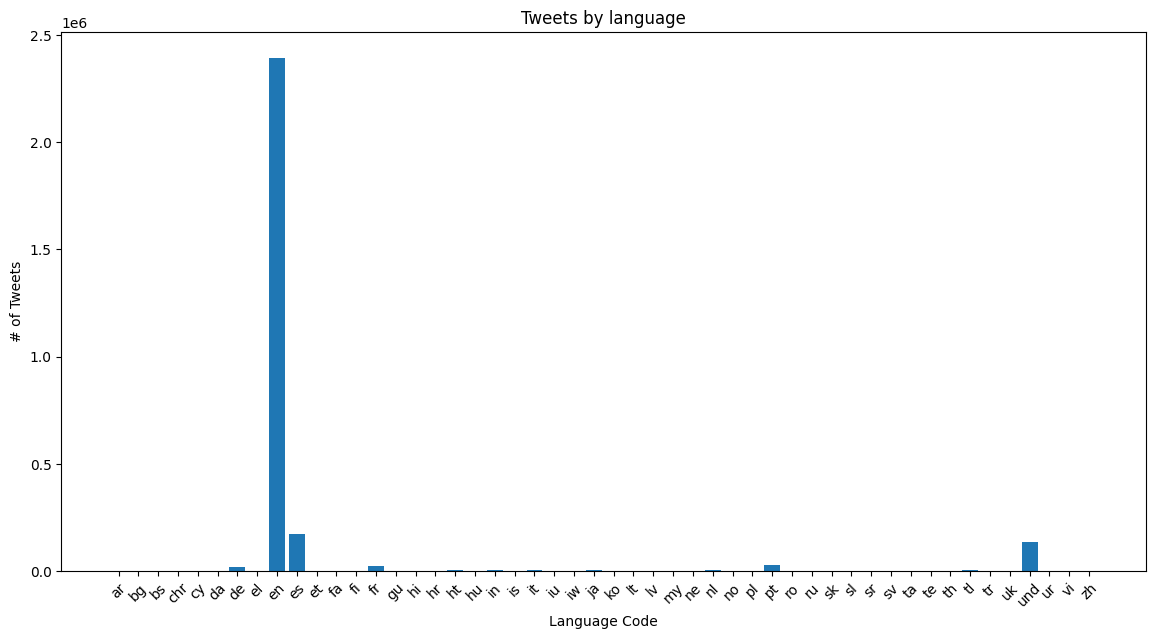

In [53]:
tweet_language_counts = np.unique(tweet_meta_data['tweet_language'], return_counts=True)
plt.figure(figsize=(14,7))
plt.bar(tweet_language_counts[0], tweet_language_counts[1])
plt.xlabel('Language Code')
plt.ylabel('# of Tweets')
plt.title('Tweets by language')
plt.xticks(rotation=45)
plt.show()

In [54]:
lang_filter_arr = np.array([l == 'en' for l in tweet_meta_data['tweet_language']])
for k in tweet_meta_data:
    tweet_meta_data[k] = np.array(tweet_meta_data[k])[lang_filter_arr]
print(f"Total # of English tweets: {len(tweet_meta_data['views'])}")

Total # of English tweets: 2393732


Now let's look at how the other numeric features are distributed and correlated.

In [55]:
numeric_features = ['views', 'retweets', 'user_followers', 'tweet_ranking']
for n in numeric_features:
    min_mean_max(tweet_meta_data[n], n)

views - min: 0.00, mean: 7458.14, max: 64366229.00
retweets - min: 1.00, mean: 2.28, max: 21919.00
user_followers - min: 0.00, mean: 7822.06, max: 64319726.00
tweet_ranking - min: 2.24, mean: 4.45, max: 10.57


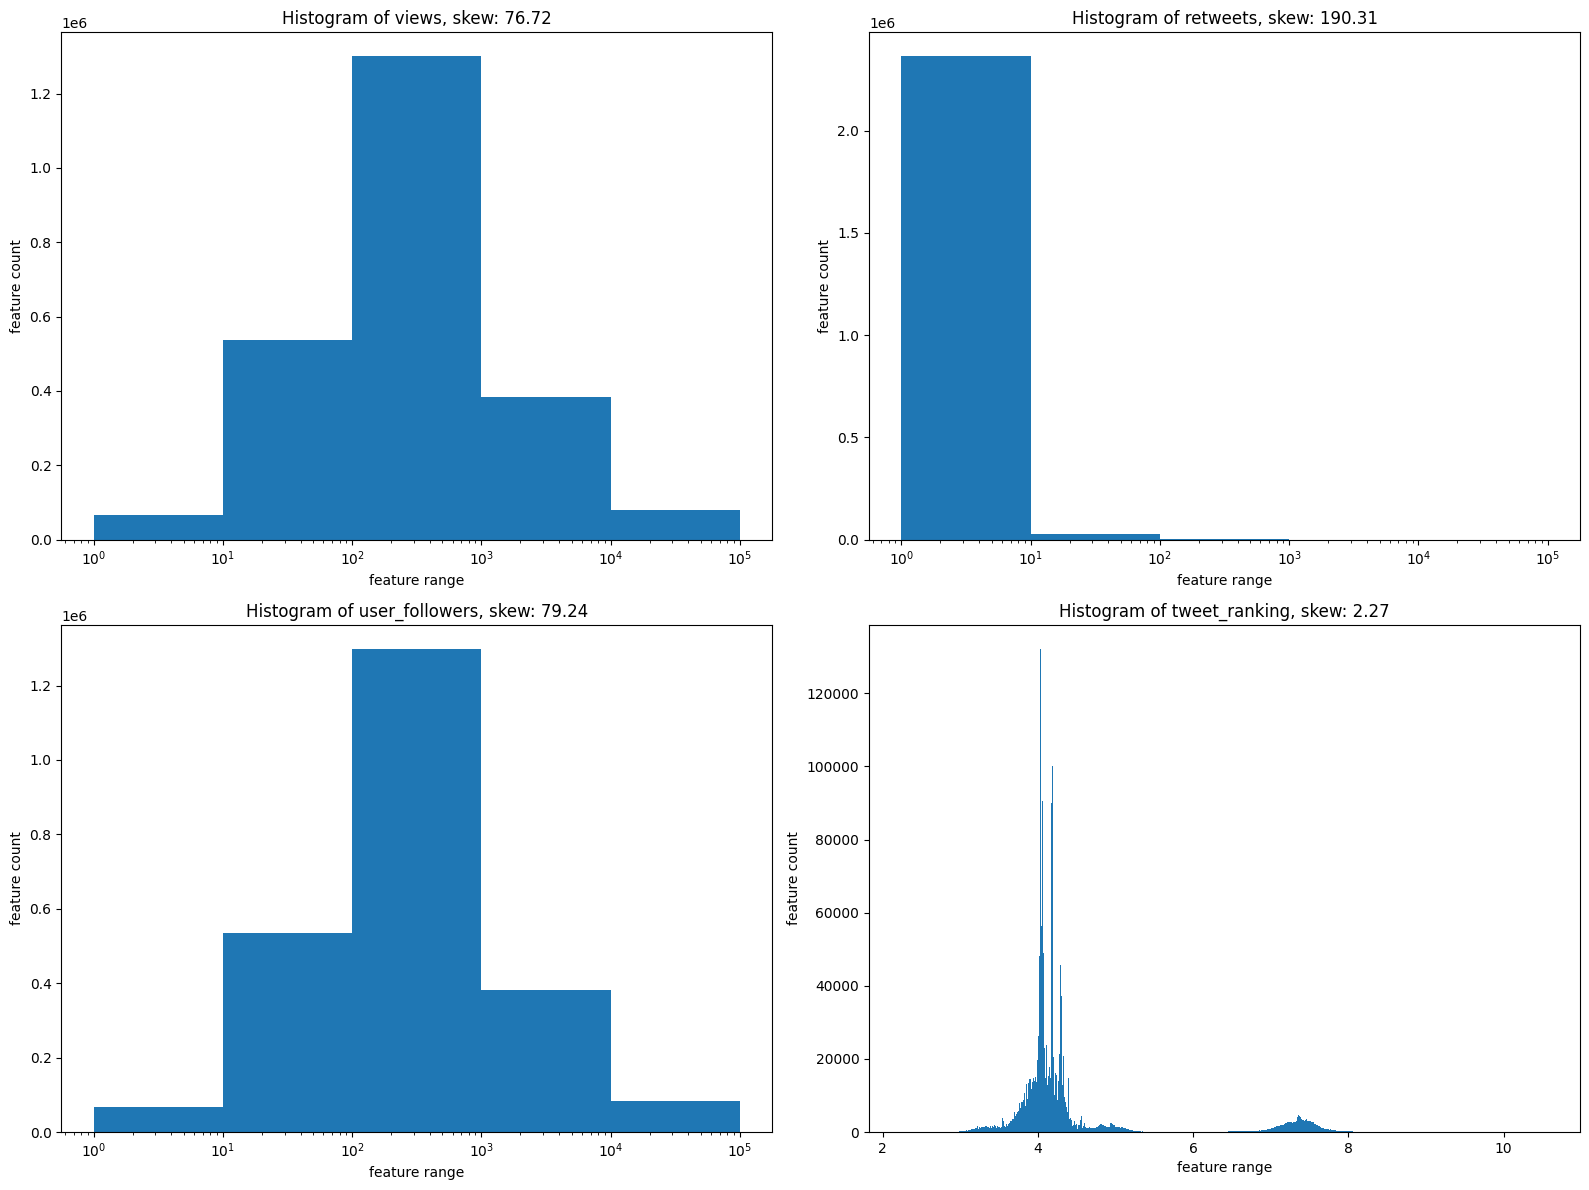

In [56]:
exp_bins = 10**np.arange(0,6)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
flat_axes = axes.flatten()
log_features = ['views', 'user_followers','retweets']

for ax, f_name in zip(flat_axes, numeric_features):

    if f_name in log_features:
        xscale = 'log'
        bins = exp_bins
    else:
        xscale = 'linear'
        bins = 1000

    ax.hist(tweet_meta_data[f_name], bins=bins)
    ax.set(xlabel='feature range', ylabel='feature count',
           title=f'Histogram of {f_name}, skew: {skew(tweet_meta_data[f_name]):.2f}', xscale=xscale)

fig.tight_layout()

We can observe from the distributions that "views" and "user_followers" are highly correlated. This makes sense, as we would expect twitter to show a user's tweet to all following users. Retweets appear to be quite rare though and the mysterious "ranking" metric seems unrelated to the number of views. That said, it might correlate more strongly against some log-features so we will check this.

<AxesSubplot: >

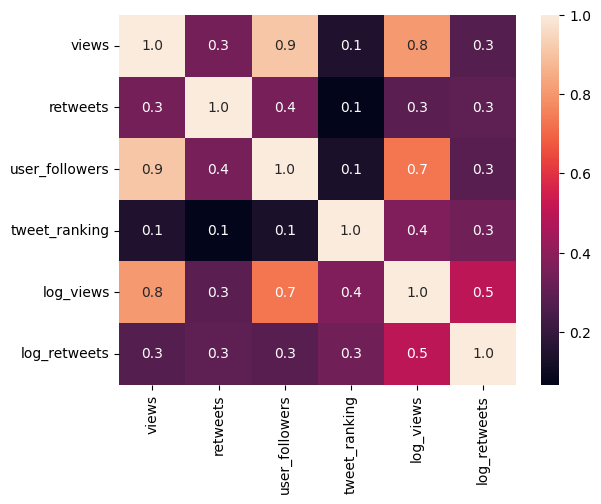

In [66]:
corr_features = [v for k,v in tweet_meta_data.items() if k in numeric_features]
corr_features.append(np.sqrt(tweet_meta_data['views']))
corr_features.append(np.log(tweet_meta_data['retweets']))
corr_feature_names = numeric_features + ['log_views', 'log_retweets']
corrs = np.corrcoef(corr_features)
sns.heatmap(corrs, annot=True, fmt='.1f', xticklabels=corr_feature_names, yticklabels=corr_feature_names)
print()

In [68]:
not_retweets = np.unique(tweet_meta_data['is_retweet'], return_counts=True)[1][0]
print(f"# of tweets that are retweets: {len(tweet_meta_data['views']) - not_retweets}")

# of tweets that are retweets: 0


We can observe in the above, that views and followers are highly correlated. As such, predicting the direct number of views a tweet get is trivial and therefore not very interesting. More interesting would be to aggregate all additional views from retweets and have total view count, but unfortunately none of the tweets in this dataset are retweets. As such, we will not try to predict views or total views, but instead the retweets. Lastly regarding the "ranking" metric, it does seem to slightly correlate with the log-scale of views, but given that it is likely a twitter-generated score post-tweet, we will not consider it a candidate feature for prediction from here on out.

## Feature Engineering

With the above information, let's pick the following features to predict retweets.

1. **Number of followers** - this seems obvious as no matter what a user tweets, the more people see, the likelier it is that it will be retweeted. Arguably, there is probably also some relationship to the content the user produces and the number of followers (i.e people are more inclined to follow users who tweet interesting and hence retweetable material).
2. **Tweet hashtags + current activity** - we hypothesise that there is likely some significance as to how many related tweets have been made previously. More activity around a hashtag will likely yield more retweets. As such we will measure the number of related hashtags that have been used at certain intervals before the tweet is posted (e.g 10 minutes before, 30 minutes before, 1 hour before). This can be seen as a mini-time series feature.
3. **The tweet itself** - although likely more difficult to use given it is text, tweets are quite uniform in length so we can generate some embeddings for it.

In [ ]:
# Out of time. Too many competing deadlines and I have an exam tomorrow. Next steps would pretty straightforward: extract tweet hashtags to create time-series of activity, from which we get our feature. Use first 2 features for trivial baselines (e.g linear regressions, random forests) and then add text for a large language model.
